In [40]:
import pandas as pd
import numpy as np
import os

from time import time

from collections import namedtuple
import gensim
from gensim.models import doc2vec
%matplotlib inline
import seaborn as sns
sns.set_style("darkgrid")
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN

import random

In [41]:
descriptions_clear = list(pd.read_csv('descriptions_clear.csv')['0'])
descriptions = list(pd.read_csv('descriptions.csv')['0'])

docs = []
analyzedDocument = namedtuple('AnalyzedDocument', 'words tags')
for i, text in enumerate(descriptions_clear):
    docs.append(analyzedDocument(text.split(), [i]))

print('Количество строк:', len(descriptions_clear))
print('Количество уникальных', len(np.unique(descriptions_clear)))

Количество строк: 1834
Количество уникальных 1570


In [42]:
time_start = time()
model = doc2vec.Doc2Vec(docs,
                        vector_size = 20,
                        window = 3,
                        min_count = 1,
                        dm = 0,
                        epochs = 50,
                        hs = 1,
                        dbow_words = 0)

# model.build_vocab(docs)

model.train(docs,
            total_examples=model.corpus_count,
            epochs=model.epochs)

print('Doc2Vec done! Time elapsed: {} seconds'.format(time()-time_start))

Doc2Vec done! Time elapsed: 7.1022047996521 seconds


Взглянем, какие предложения расположены наиболее близко друг к другу по мнению Doc2Vec.

In [43]:
for k in range(5):
    i =  random.choice(range(len(descriptions)))
    print(f'Предложение:\n\t{descriptions[i]}\nНаиболее близкие к нему:')
    for j in model.docvecs.most_similar(i)[:3]:
        print(f'\t{descriptions[j[0]]}')
    print()


Предложение:
	Отель с золотыми элементами в интерьере , категории: Усадьбы
Наиболее близкие к нему:
	Отель с классическим интерьером, категории: Культура и Искусство Отели, гостиницы, хостелы Усадьбы
	Отель с классическими номерами, категории: Отели, гостиницы, хостелы Якиманка
	Дом отдыха советской элиты, категории: Общественные учреждения Культура и Искусство Медицинские учреждения Спортивные учреждения Отели, гостиницы, хостелы Концертные залы Бассейны КИНОТЕАТРЫ Санатории

Предложение:
	Ретрокар, категории: Ночные клубы и бары Салоны красоты и частные клиники Якиманка ПРОСТРАНСТВА
Наиболее близкие к нему:
	хижина чернил, категории: Салоны красоты и частные клиники ПРОСТРАНСТВА Печатники
	Beauty salon, категории: Салоны красоты и частные клиники Якиманка
	Молодёжный бар с граффити , категории: Ночные клубы и бары Якиманка

Предложение:
	Ресторан колизей, категории: Рестораны и кафе Аэропорт
Наиболее близкие к нему:
	Народный ресторан, категории: Рестораны и кафе Арбат
	Кафе с сотами

### Уменьшение размерности

In [44]:
texts, vectors = [], []
for i in range(len(model.docvecs)):
    texts = np.append(texts, descriptions[i])    
    vectors.append(model.docvecs[i])
vectors = pd.DataFrame(vectors)

In [45]:
time_start = time()
tsne = TSNE(n_components=2,
            perplexity=20,
            early_exaggeration=15,
            init='random')
tsne_res = tsne.fit_transform(vectors)
print('TSNE done! Time elapsed: {} seconds'.format(time()-time_start))

TSNE done! Time elapsed: 10.999550819396973 seconds


In [46]:
time_start = time()
umap_ = umap.UMAP(n_components=2,
                  n_neighbors=3,
                  min_dist=0.1)
umap_res = umap_.fit_transform(vectors)
print('UMAP done! Time elapsed: {} seconds'.format(time()-time_start))

UMAP done! Time elapsed: 6.091167449951172 seconds


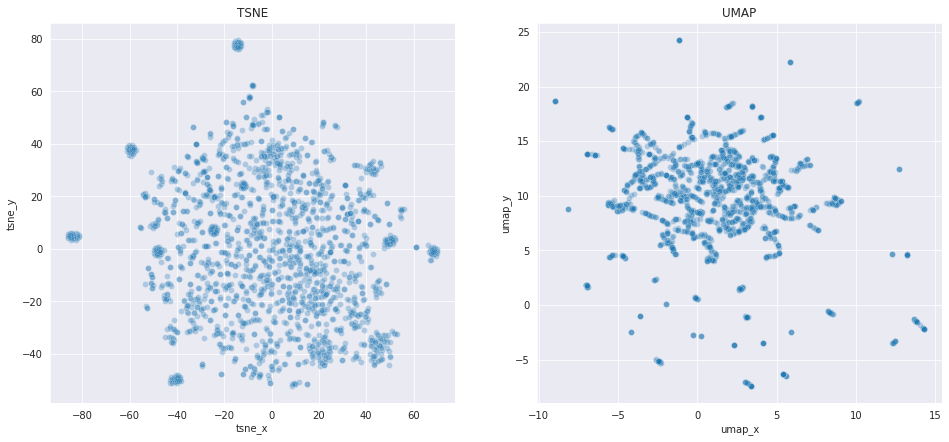

In [47]:
df_picture = pd.DataFrame({'sentence':texts,
                          'tsne_x':tsne_res[:,0], 'tsne_y':tsne_res[:,1],
                          'umap_x':umap_res[:,0], 'umap_y':umap_res[:,1]})
plt.figure(figsize=(16,7))
ax1 = plt.subplot(1, 2, 1)
sns.scatterplot(x="tsne_x", y="tsne_y",data=df_picture,alpha=0.3,ax=ax1)
ax1.set_title('TSNE')

ax2 = plt.subplot(1, 2, 2)
sns.scatterplot(x="umap_x", y="umap_y",data=df_picture,alpha=0.3,ax=ax2)
ax2.set_title('UMAP')
plt.show()

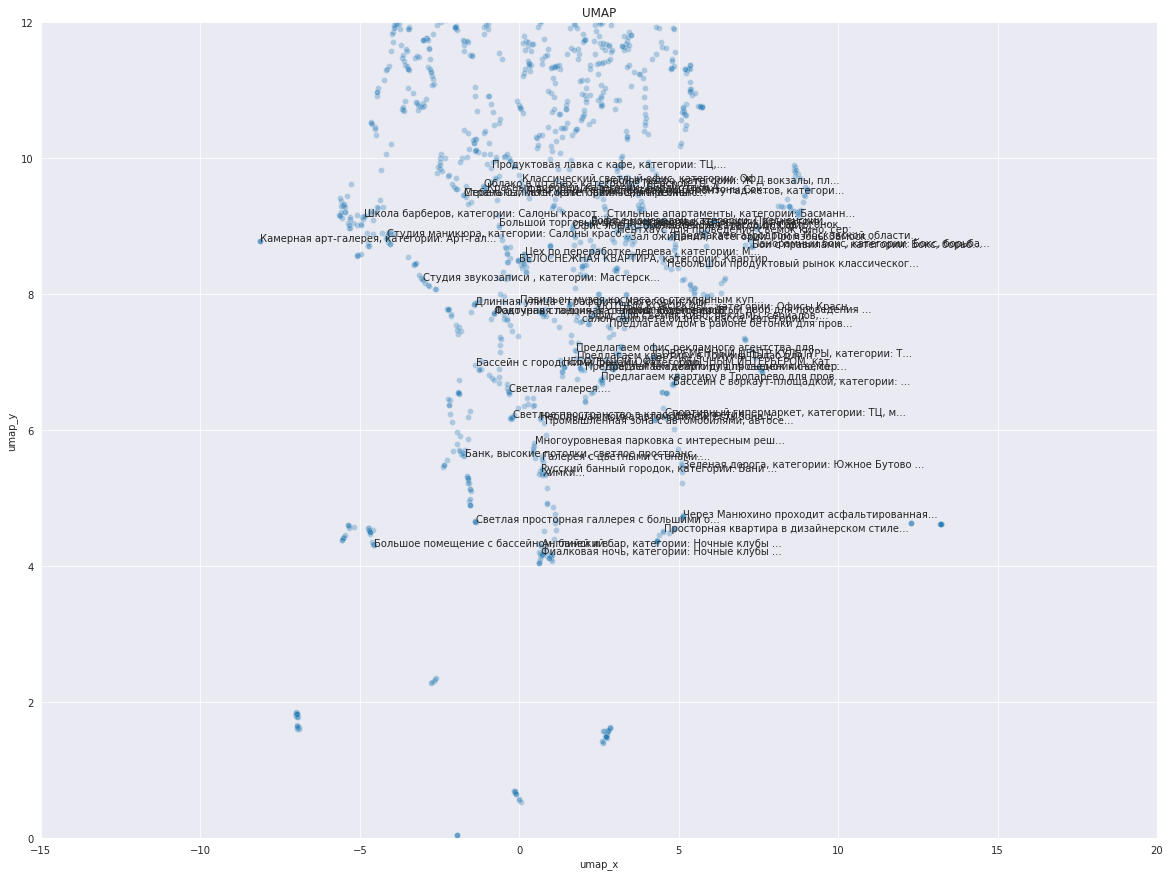

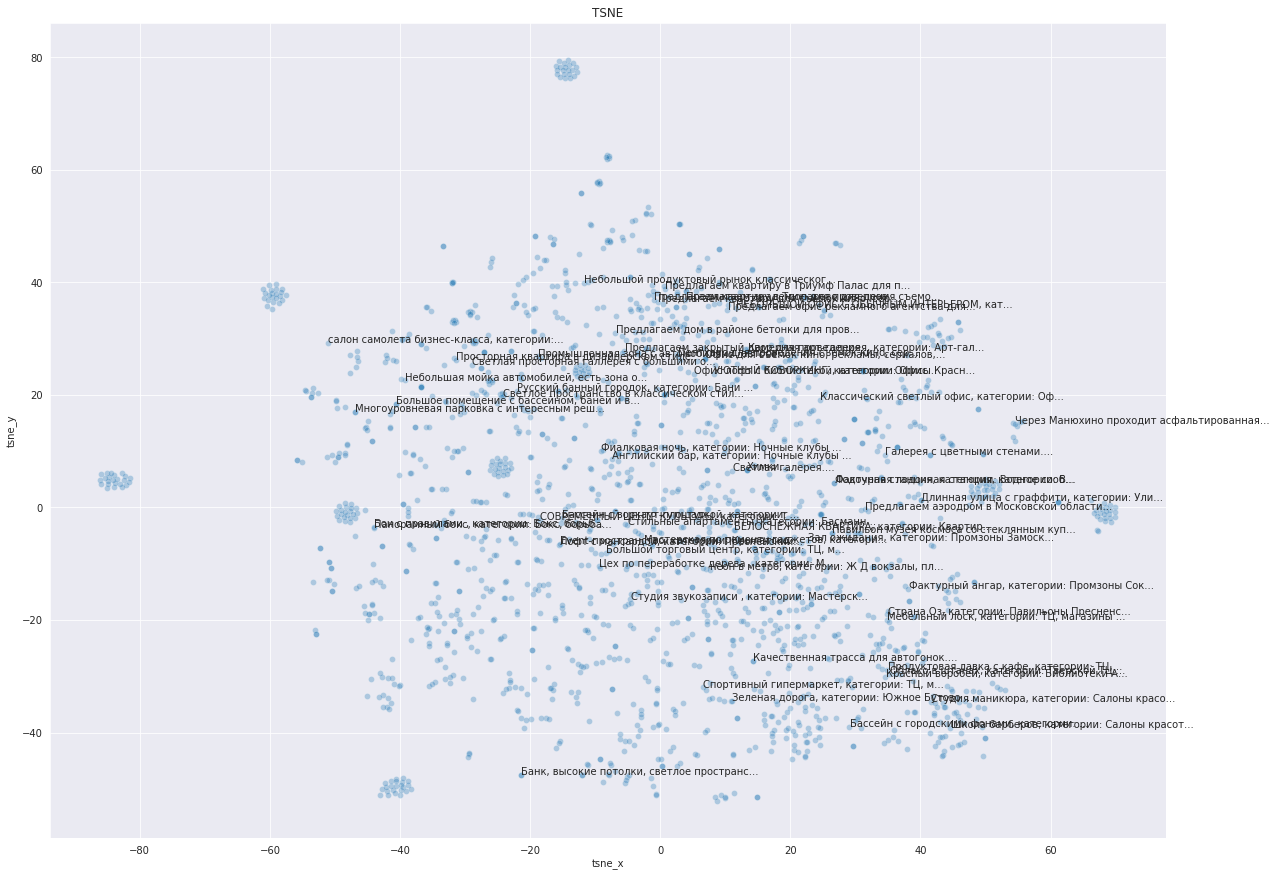

In [48]:
ind = random.sample(range(df_picture.shape[0]), 150)

labeled_data = df_picture.loc[df_picture.index[ind],:]
q1 = (labeled_data['umap_x'] < 17) & (labeled_data['umap_x'] > -10)
q2 = (labeled_data['umap_y'] < 10) & (labeled_data['umap_y'] > 2)
labeled_data = labeled_data[q1 & q2]

x, y, value = labeled_data.umap_x, labeled_data.umap_y, labeled_data.sentence
plt.figure(figsize=(20,15))
sns.scatterplot(x="umap_x", y="umap_y",data=df_picture,alpha=0.3)
a = pd.concat({'x': x, 'y': y,'val':value}, axis=1)
for i, point in a.iterrows():
    plt.text(point['x']+.02, point['y'], point['val'][:40]+'...')
plt.title('UMAP')
plt.xlim((-15,20))
plt.ylim((0,12)) 
plt.show()

x, y, value = labeled_data.tsne_x, labeled_data.tsne_y, labeled_data.sentence
plt.figure(figsize=(20,15))
sns.scatterplot(x="tsne_x", y="tsne_y",data=df_picture,alpha=0.3)
a = pd.concat({'x': x, 'y': y,'val':value}, axis=1)
for i, point in a.iterrows():
    plt.text(point['x']+.02, point['y'], point['val'][:40]+'...')
plt.title('TSNE')
plt.show()

### Кластеризация  


K-Means clustering done! Time elapsed:0.22582411766052246 seconds
Agglomerative Clustering clustering done! Time elapsed:0.05122661590576172 seconds
DBSCAN clustering done! Time elapsed:0.008335351943969727 seconds


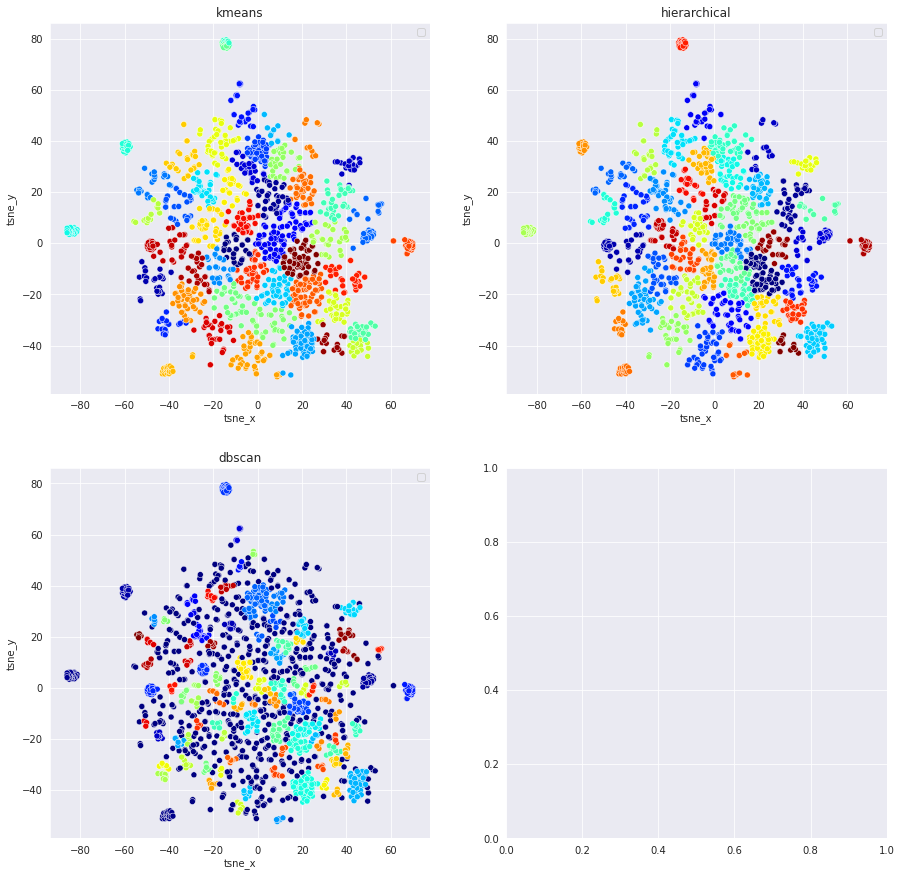

In [49]:
n_clusters = 50
# X = df_picture.loc[:, ['umap_x','umap_y']]
X = df_picture.loc[:, ['tsne_x','tsne_y']]

time_start = time()
kmeans = KMeans(n_clusters=n_clusters,init = 'random',n_init = 10).fit(X)
print(f'K-Means clustering done! Time elapsed:{time()-time_start} seconds')
time_start = time()
hierarchical = AgglomerativeClustering(n_clusters=n_clusters,linkage='ward').fit(X)
print(f'Agglomerative Clustering clustering done! Time elapsed:{time()-time_start} seconds')
# time_start = time()
# birch = Birch(n_clusters=n_clusters).fit(X)
# print(f'Birch clustering done! Time elapsed:{time()-time_start} seconds')
time_start = time()
dbscan = DBSCAN(eps=2, min_samples=5).fit(X)
print(f'DBSCAN clustering done! Time elapsed:{time()-time_start} seconds')

df_picture['labels_kmeans'] = kmeans.labels_
df_picture['labels_hierarchical'] = hierarchical.labels_
# df_picture['labels_birch'] = birch.labels_
df_picture['labels_dbscan'] = dbscan.labels_

clustering = ['kmeans','hierarchical',
#               'birch',
              'dbscan']
k = 0
fig, axs = plt.subplots(2, 2, figsize=(15,15))
for i in range(2):
    for j in range(2):
        if k == 3:
            break
        uni = list(set(df_picture[f'labels_{clustering[k]}'].unique()))
        palette = [plt.cm.jet(float(l)/max(uni)) for l in uni]
        
        sns.scatterplot(data=df_picture,
#                         x="umap_x", y="umap_y",
                        x="tsne_x", y="tsne_y",
                        hue=f'labels_{clustering[k]}',
                        ax=axs[i, j],
                        palette=palette).legend([],[])
        axs[i, j].set_title(f'{clustering[k]}')
        
        k += 1

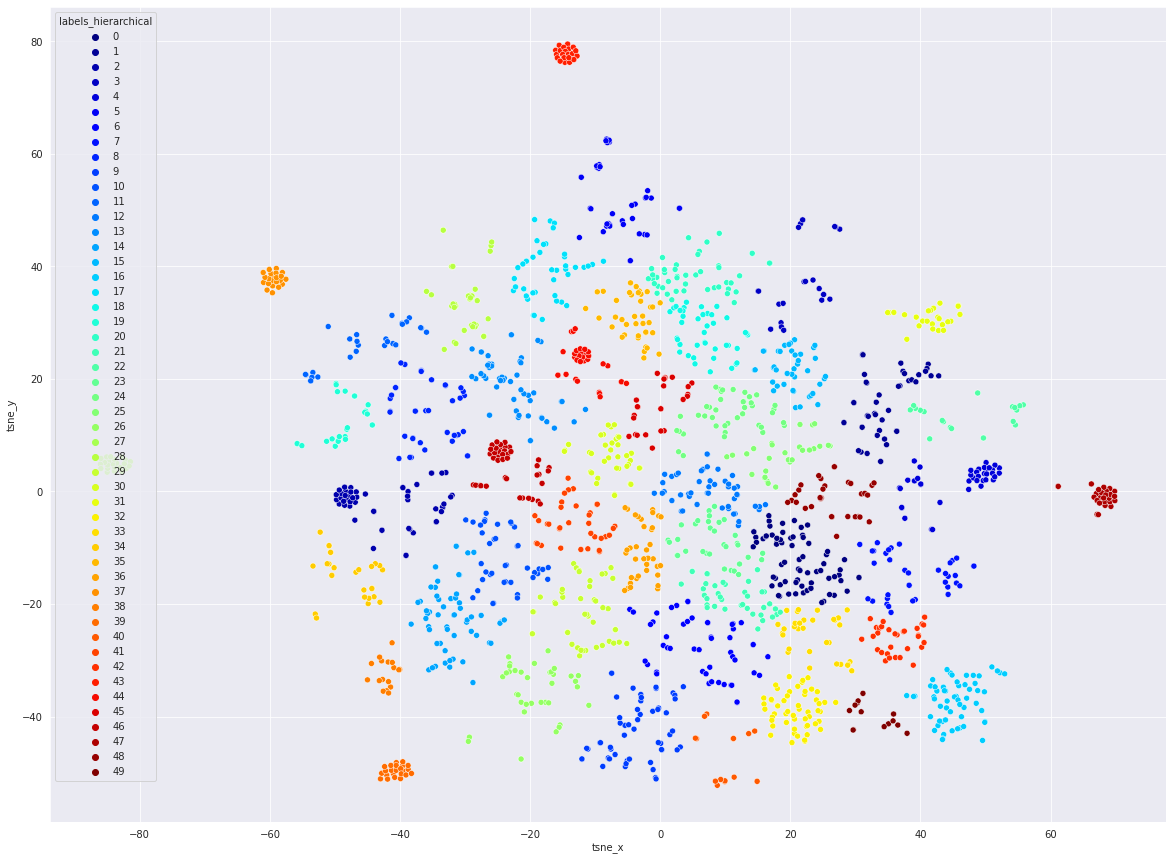

In [50]:
plt.figure(figsize=(20,15))
uni = list(set(df_picture[f'labels_hierarchical'].unique()))
palette = [plt.cm.jet(float(l)/max(uni)) for l in uni]
sns.scatterplot(data=df_picture,
                x="tsne_x", y="tsne_y",
                hue=f'labels_hierarchical',
                palette=palette)

In [51]:
df_picture['labels'] = df_picture.labels_hierarchical

clusters = df_picture.labels.unique()
for i in clusters:
    buf = df_picture[df_picture['labels'] == i].sentence
    print(f'РАЗМЕР КЛАСТЕРА: {buf.shape[0]}')
    buf = buf.drop_duplicates()
    print(f'УНИКАЛЬНЫХ ПРЕДЛОЖЕНИЙ: {buf.shape[0]}')
    for j in buf:
        print(j)
    print()

РАЗМЕР КЛАСТЕРА: 27
УНИКАЛЬНЫХ ПРЕДЛОЖЕНИЙ: 6
Школа Бортпроводников, общий вид площадок, объектов , самолетов. Зеленые насаждения.
Ангар для самолетов и вертолетов.
Школа Бортпроводников, общий вид площадок, объектов , самолетов. Зеленые насаждения. Test
Ангар для самолетов и вертолетов. Московская область                 
Ангар для самолетов и вертолетов. Московская область
московская область

РАЗМЕР КЛАСТЕРА: 23
УНИКАЛЬНЫХ ПРЕДЛОЖЕНИЙ: 1
Аэропорт, просторные внутренние пространства, эскалатор, металлические конструкции перекрытия.

РАЗМЕР КЛАСТЕРА: 23
УНИКАЛЬНЫХ ПРЕДЛОЖЕНИЙ: 1
Аэропорт, большие внутренние объемы помещений, колонны, большие площади остекления, открытые металлические конструкции.

РАЗМЕР КЛАСТЕРА: 40
УНИКАЛЬНЫХ ПРЕДЛОЖЕНИЙ: 19
Ангар для стоянки бизнес-джетов.
Ангар для стоянки бизнес-джетов. Москва                 
Свиноферма, категории: Дачные поселки
Дом-мастерская архитектора, категории: Дачные поселки
Длинная улица с граффити, категории: Улицы Центральный
Переулки 

### Построение рекомендательной системы  
Наша рекомендательная система смотрит на очередной запрос пользователя и запоминает индекс соответствующей площадки. Далее она находит по индексу она находит площадку в базе данных и смотрит на кластер, к которому эта площадка относится. Рекомендует соответственно рандомную площадку из этого же кластера.

In [52]:
def RecomedationSistem(ind_query):
    label = df_picture[df_picture['sentence'] == descriptions[ind_query]].labels.unique()[0]
    recomendation1 = random.choice(df_picture[(df_picture.index != ind_query) & (df_picture['labels'] == label)].index)
    recomendation2 = random.choice(df_picture[(df_picture.index != ind_query) & (df_picture['labels'] == label)].index)
    recomendation3 = random.choice(df_picture[(df_picture.index != ind_query) & (df_picture['labels'] == label)].index)
    most_similar_d2v = model.docvecs.most_similar(ind_query)[0][0]

    print(f'Пользователь ранее кликал на предложение:\n\t{descriptions[ind_query]}')
    print(f'Рекомендательная система предложила:\n\t{descriptions[recomendation1]}\n\t{descriptions[recomendation2]}\n\t{descriptions[recomendation3]}')
#     print(f'Модель Doc2Vec считает, что наиболее близкие запрос:\n\t{descriptions[most_similar_d2v]}')

In [54]:
for i in range(10):
    print(f'TEST {i+1}')
    RecomedationSistem(random.choice(range(len(descriptions))))
    print()


TEST 1
Пользователь ранее кликал на предложение:
	Шиномонтаж , небольшое помещение, оборудование, светлые стены
Рекомендательная система предложила:
	Небольшая мойка автомобилей, есть зона отдыха.
	Территория парка украшена клумбами, колоннами. В парке имеется пруд.
	Автомойка с зоной отдыха.

TEST 2
Пользователь ранее кликал на предложение:
	Ледовый дворец спорта, категории: Ледовые холлы
Рекомендательная система предложила:
	Современная городская застройка, бизнес среда, комплекс Москва Сити, высотные здания, стеклянные фасады, внутренняя территория.
	Просторное помещение, открытые бетонные конструкции, стены из красного кирпича.
	Внушительный автосервис, категории: Мастерские Автосервисы, автотрассы

TEST 3
Пользователь ранее кликал на предложение:
	Советская мастерская, категории: Мастерские и студии Замоскворечье
Рекомендательная система предложила:
	Студия звукозаписи , категории: Мастерские и студии Преображенское
	ТВОРЧЕСКАЯ МАСТЕРСКАЯ, категории: Мастерские и студии Якиманка
	